In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import palettable
import squarify

import connectheroku as cheroku # connect database function
import warnings; warnings.filterwarnings(action='ignore')

In [225]:
def format_func(value, tick_number):
    """Take a value as input and convert into a
    string in MM for yticks labels

    Args:
        value (_type_): _description_
        tick_number (_type_): _description_

    Returns:
        _type_: format axis number in MM
    """
    if value >= 1e6:
        return r"${:.1f}MM$".format(value / 1e6)
    elif value >= 1e4:
        return r"${:.1f}M$".format(value / 1e3)
    else:
        return r"${}$".format(value)

In [226]:
large = 22; med = 16; small = 12
params = {'axes.titlesize' : large,
          'legend.fontsize' : med,
          'figure.figsize' : (16, 10),
          'axes.labelsize' : med,
          'xtick.labelsize' : med,
          'ytick.labelsize' : med,
          'figure.titlesize' : large
}
plt.rcParams.update(params)
sns.set_style('whitegrid')
all_shapes = list(mpl.markers.MarkerStyle.markers.keys())
blue, orange = sns.color_palette()[:2]

In [227]:
credential_file = '/Users/aliglara/Documents/MyGit/apis/credential_keys.json'

# Exploratory Data Analysis (EDA)

The EDA was split in the following sections:
1. General population and Homeless population data
1. Gross rent increase
1. Income and rent expenses by bachelor's professional or above

## Introduction 
### Scope

The goal of this project was to create a data-driven tool to visualize whether there is a link between rising rent cost and homelessness among people who possesses a bachelor's degree or above in the United States.

### Dataset

The data used in this project was obtained from two US-official sources between 2015 to 2020.

First, the estimated US population will be grabbed from the US Census website, filtered by the following topics:

1. Geography > Nation > United States
2. Population and People > Population and People

Besides the broad information that can be obtained, this project was focused on the following features:

- Name of the state
- Year
- Total population
- Population in households
- Educational attainment
- Employment status
- Income
- Housing tenure
- Gross rent cost

Second, The estimate of homelessness population by state was pulled out from the HUD Exchange website

**The dataset was stored on my Heroku server to brush up on SQL coding. However, the original csv files are available in the GitHub repository. Click on -> ([link](https://github.com/aliglara/capstone-c1-DA/tree/main/data))**


## US population and homeless populatio information

### Grabbing and combining datasets
Let's combine the information from the Census.gov and HUC dataset using a SQL

In [228]:
query = (
    "with ctedata as "
"    ( " # Select data from homeless population and add state name and region
    "    SELECT "
    "    ohr.year, "
    "    ohr.abbreaviation, "
    "    sr.name, "
    "    ohr.homeless_pop, "
    "    sr.region "
    "    FROM overall_homeless AS ohr "
    "    JOIN state_region AS sr ON "
    "       ohr.abbreaviation = sr.abbreviation "
    "    WHERE ohr.abbreaviation is not null "
"    ) "
"    SELECT upop.year, " # Extract data from census.gov and add info from ctedata
"           upop.name_state, "
"           cte.abbreaviation, "
"           upop.population, "
"           cte.homeless_pop, "
"           upop.population_in_households, pop_in_labor_force, "
"           upop.bachelor_or_higher_pop_in_labor_force, "
"           upop.total_population_25_years_and_over_educ_attainment, "
"           upop.population_25_years_and_over_no_schooling_completed, "
"           upop.population_25_years_and_over_bachelor_degree, "
"           upop.population_25_years_and_over_master_degree + upop.population_25_years_and_over_doctorate_degree AS  pop_25y_master_over, "
"           cte.region "
"    FROM us_population as upop "
"    JOIN ctedata AS cte ON (upop.year = cte.year) AND (upop.name_state = cte.name) "
)

raw_data_df = cheroku.make_query(query, "c1_capstone", credential_file)

In [229]:
raw_data_df.head()

,year,name_state,abbreaviation,population,homeless_pop,population_in_households,pop_in_labor_force,bachelor_or_higher_pop_in_labor_force,total_population_25_years_and_over_educ_attainment,population_25_years_and_over_no_schooling_completed,population_25_years_and_over_bachelor_degree,pop_25y_master_over,region
0,2015,Mississippi,MS,2992333,1983,1104371,1335130,268930,1952337,28332,253036,223786,South
1,2015,Missouri,MO,6083672,6482,2374180,3062893,813903,4097212,35703,706922,640856,South
2,2015,Montana,MT,1032949,1709,414804,516733,141994,706329,3347,144135,100088,West
3,2015,Nebraska,NE,1896190,2744,744159,1025079,275822,1232583,12252,244556,180058,Midwest
4,2015,Nevada,NV,2890845,8743,1042065,1455305,297028,1968167,32904,304948,224390,West


In [230]:
# Verify if there are null values

print(raw_data_df.isnull().sum())

year                                                   0
name_state                                             0
abbreaviation                                          0
population                                             0
homeless_pop                                           0
population_in_households                               0
pop_in_labor_force                                     0
bachelor_or_higher_pop_in_labor_force                  0
total_population_25_years_and_over_educ_attainment     0
population_25_years_and_over_no_schooling_completed    0
population_25_years_and_over_bachelor_degree           0
pop_25y_master_over                                    0
region                                                 0
dtype: int64


In [231]:
raw_data_df.rename({
    "year" : "Year" ,
    "name_state" : "State name",
    "abbreaviation" : "State abbr",
    "population" : "Population",
    "homeless_pop" : "Homeless pop",
    "population_in_households" : "Pop in households",
    "pop_in_labor_force" : "Pop in labor force",
    "bachelor_or_higher_pop_in_labor_force" : "Bachelor+ in labor force",
    "total_population_25_years_and_over_educ_attainment": "Pop. 25year+ educ",
    "population_25_years_and_over_no_schooling_completed": "Pop. 25year+ no schooling",
    "population_25_years_and_over_bachelor_degree": "Pop. 25year+ bachelor",
    "pop_25y_master_over": "Pop. 25year+ master over",
    "region" : "Region"
}, axis='columns', inplace=True)

In [232]:
indexed_data_df = raw_data_df.copy()
indexed_data_df.set_index(["Year", "State name"], inplace=True)

In [233]:
indexed_data_df.head()

State abbr  Population  Homeless pop  Pop in households  \
Year State name                                                            
2015 Mississippi         MS     2992333          1983            1104371   
     Missouri            MO     6083672          6482            2374180   
     Montana             MT     1032949          1709             414804   
     Nebraska            NE     1896190          2744             744159   
     Nevada              NV     2890845          8743            1042065   

                  Pop in labor force  Bachelor+ in labor force  \
Year State name                                                  
2015 Mississippi             1335130                    268930   
     Missouri                3062893                    813903   
     Montana                  516733                    141994   
     Nebraska                1025079                    275822   
     Nevada                  1455305                    297028   

                  Pop. 25year+ educ  Pop. 25year+ no schooling  \
Year State name                                                  
2015 Mississippi            1952337                      28332   
     Missouri               4097212                      35703   
     Montana                 706329                       3347   
     Nebraska               1232583                      12252   
     Nevada                 1968167                      32904   

                  Pop. 25year+ bachelor  Pop. 25year+ master over   Region  
Year State name                                                             
2015 Mississippi                 253036                    223786    South  
     Missouri                    706922                    640856    South  
     Montana                     144135                    100088     West  
     Nebraska                    244556                    180058  Midwest  
     Nevada                      304948                    224390     West

### How the US population has changed from 2015 to 2020

In [234]:
# Perform some aggregation functions on the data
# Pivot table for total number per year
total_pt = pd.pivot_table(
    data= indexed_data_df,
    index="Year",
    values=["Population", "Homeless pop"],
    aggfunc=sum
)

In [235]:
def norm_column(serie):
    return serie/serie.max()

Let's add 4 columns to the dataframe:
- Homeless population percentage
$$ \text{Homeless pop (\%)} = \frac{\text{Homeless pop}}{\text{Population}} \; 100 $$
- Change of homeless population percentage yearly
- Normalized homeless population 
$$ \text{Normalized homeless population} = \frac{\text{homeless population(i)}}{\max(\text{homeless population})} $$
- Normalized total population
$$ \text{Normalized population} = \frac{\text{population(i)}}{\max(\text{population})} $$

In [236]:
total_pt["Homeless pop (%)"] = total_pt["Homeless pop"] / total_pt["Population"] * 100
total_pt["Homeless change (%)"] = total_pt["Homeless pop"].pct_change() * 100
total_pt["Homeless adim"] = norm_column(total_pt["Homeless pop"])
total_pt["Pop adim"] = norm_column(total_pt["Population"])

In [237]:
total_pt

,Homeless pop,Population,Homeless pop (%),Homeless change (%),Homeless adim,Pop adim
Year,,,,,,
2015,559194,324893003,0.172116,NaN,0.972757,0.980267
2016,544951,326538822,0.166887,-2.547059,0.947980,0.985233
2017,545690,329056355,0.165835,0.135609,0.949265,0.992829
2018,547200,330362592,0.165636,0.276714,0.951892,0.996770
2019,561563,331433217,0.169435,2.624817,0.976878,1.000000
2020,574855,329824950,0.174291,2.366965,1.000000,0.995148


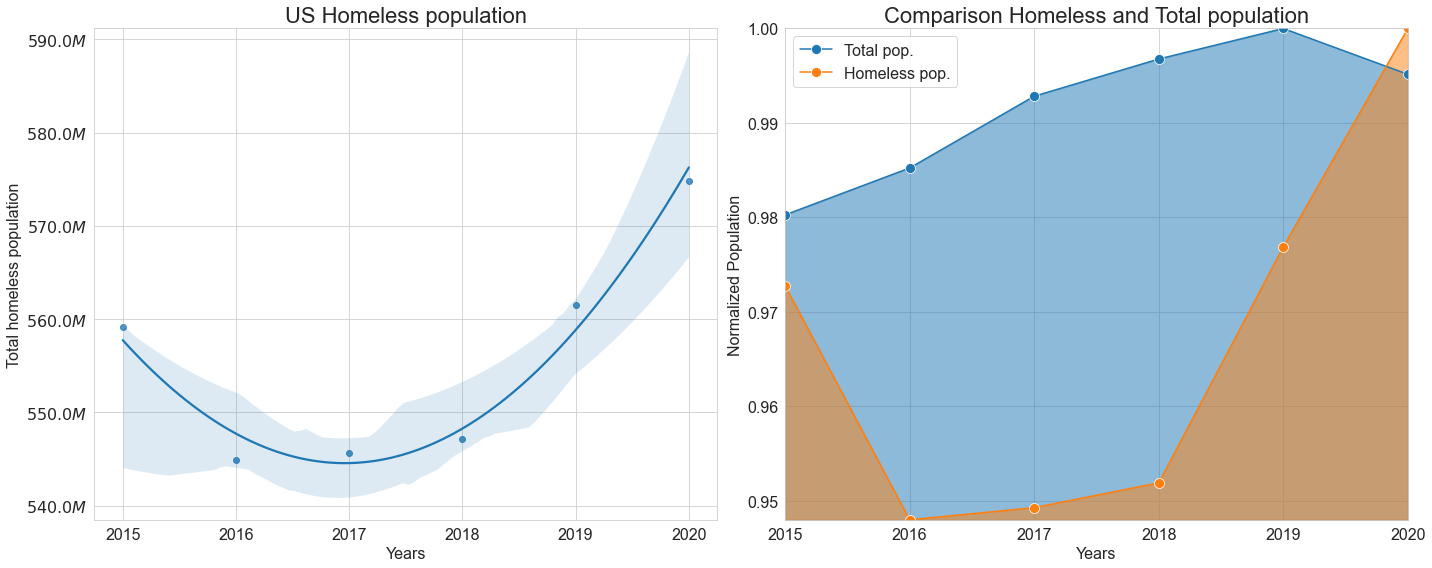

In [238]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
_ = sns.regplot(x=total_pt.index,
                y="Homeless pop",
                data=total_pt,
                ax=ax1,
                order=2
                )

_ = sns.lineplot(x=total_pt.index, y="Pop adim",
                 data=total_pt,
                 ax=ax2, color=blue, label='Total pop.',
                 marker='o', markersize=10)
ax2.fill_between(x=total_pt.index,
                 y1=total_pt["Homeless adim"].min(),
                 y2=total_pt["Pop adim"],
                 color=blue,
                 alpha=0.5)
_ = sns.lineplot(x=total_pt.index, y="Homeless adim",
                 data=total_pt,
                 ax=ax2, color=orange, label='Homeless pop.',
                 marker='o', markersize=10)
ax2.fill_between(x=total_pt.index,
                 y1=total_pt["Homeless adim"].min(),
                 y2=total_pt["Homeless adim"],
                 color=orange,
                 alpha=0.5)
ax2.set(ylabel="Normalized Population", xlabel="Years",
       xlim=[2015, 2020], ylim=[total_pt["Homeless adim"].min(), 1])
ax2.legend(loc='best')
ax2.set_title("Comparison Homeless and Total population")

ax1.set(ylabel="Total homeless population", xlabel="Years")
ax1.set_title("US Homeless population")
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_func))

plt.tight_layout()
plt.show()

Takeaways:
- Since 2018, the total US-homeless population has increased an average of 2.5% yearly
- Based on the Census.gov database, the highest US homeless population was registered in 2020
- The US population registered a 0.5%-decrease between 2019 and 2020
- The homeless population is 0.16% of the total population from 2015 to 2020

### How the homeless population is distributed on the US territories

In [239]:
years = raw_data_df["Year"].unique().tolist()

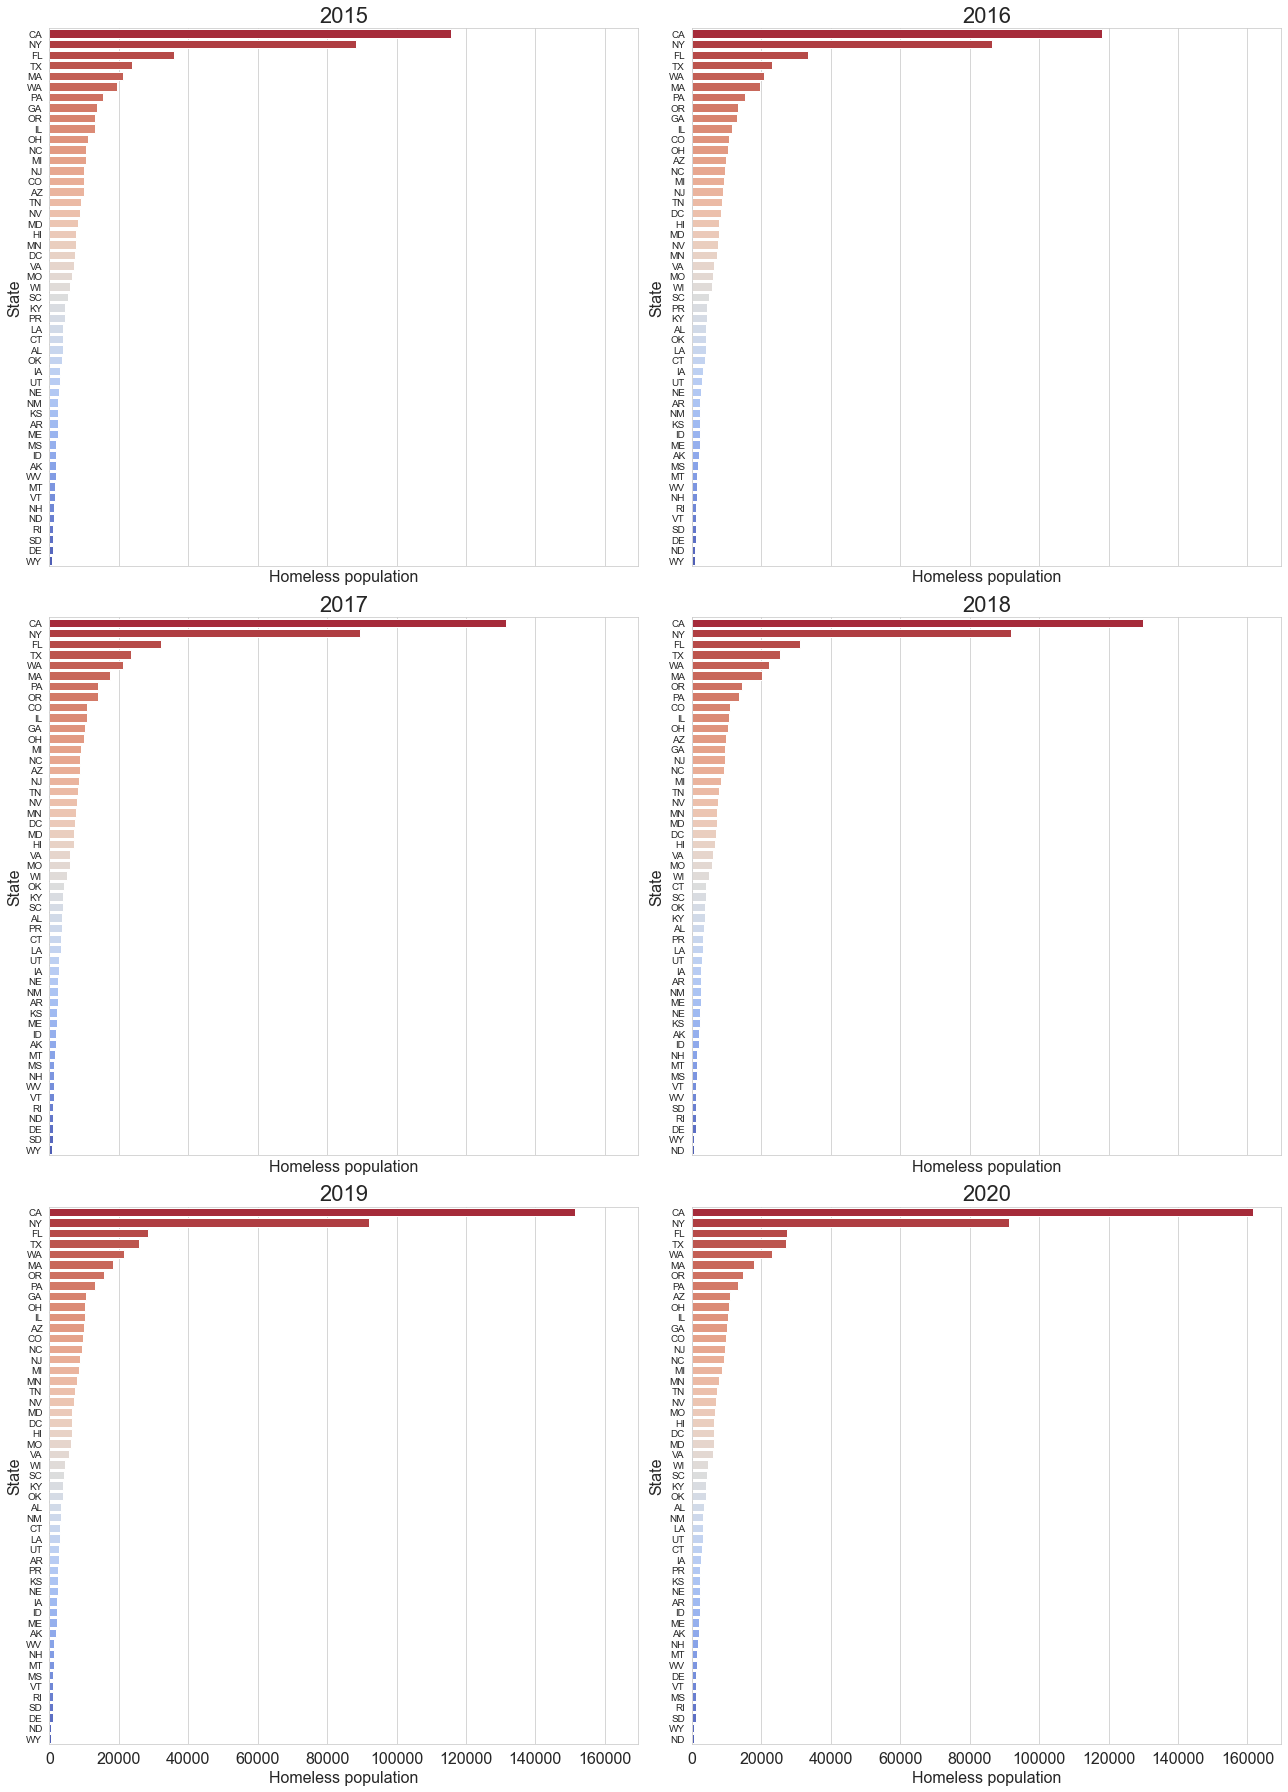

In [240]:
_, axes = plt.subplots(3, 2, figsize=(18, 25), sharex=True)
for year, ax in zip(years, axes.ravel()):
    df = raw_data_df[raw_data_df["Year"] == year].sort_values(by="Homeless pop", ascending=False)
    _ = sns.barplot(y="State abbr", x="Homeless pop", data=df, ax=ax, palette="coolwarm_r")
    ax.set_title(year)
    ax.set(xlabel="Homeless population", ylabel="State")
    ax.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.show()

Based on those figures, CA is the state with a higher homeless population. Besides, there were no massive changes in the states with homeless people during the last four years.

Let's find out what are the top 10 states for each year

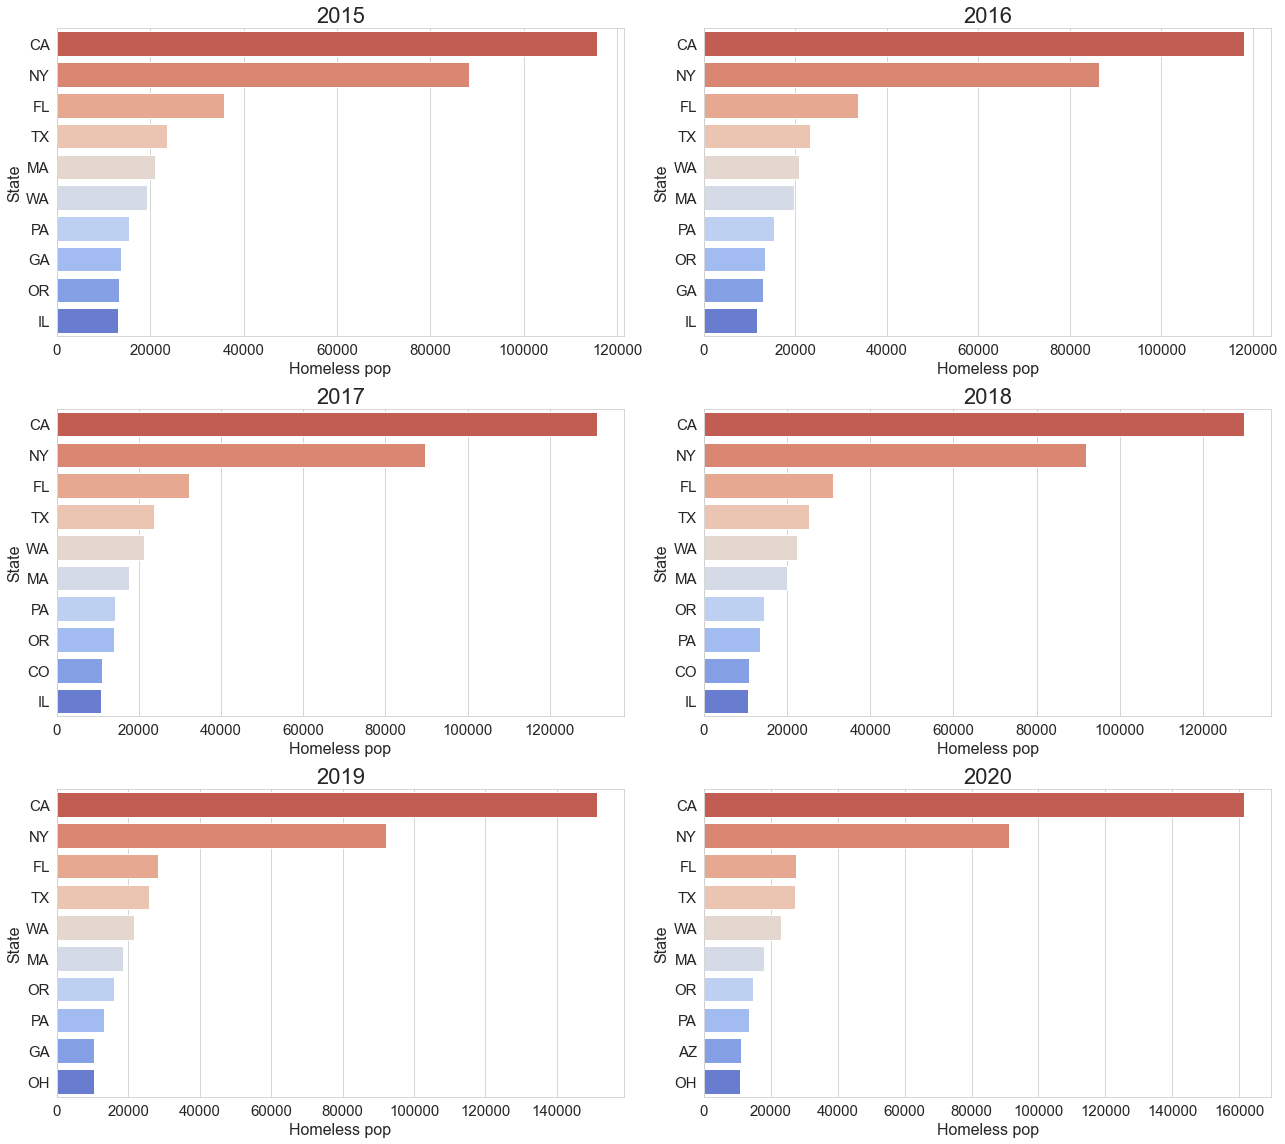

In [241]:
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
for year, ax in zip(years, axes.ravel()):
    df = raw_data_df[raw_data_df["Year"] == year].sort_values(by="Homeless pop", ascending=False)
    _ = sns.barplot(y="State abbr", x="Homeless pop", data=df.head(10),
                    palette="coolwarm_r", ax=ax, orient="h")
    ax.set_title(year)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set(xlabel="Homeless pop", ylabel="State")
plt.tight_layout()
plt.show()

What are the states that has been reported on the top 10 list between 2015 to 2020?

The top ten states list isn't kept constant during the period study. 
Let's find out which states were on the top 10 list per year

In [242]:
top_states_index = []
for year in years:
    (top_states_index.extend(raw_data_df[raw_data_df["Year"] == year].sort_values(by="Homeless pop", 
                                                                                  ascending=False).head(10).index.to_list()))

In [243]:
# Let's put this into a dataframe
top_states_df = raw_data_df.loc[top_states_index, "State name"]
top_states_df.reset_index(inplace=True, drop=True)

In [244]:
name_top_states = top_states_df.unique()
print("Between {} and {}, these are the {} states that has been reported in the top 10 homeless population".format(min(years), max(years), len(name_top_states)))

Between 2015 and 2020, these are the 13 states that has been reported in the top 10 homeless population


In [245]:
pd.Series(name_top_states)

0        California
1          New York
2           Florida
3             Texas
4     Massachusetts
5        Washington
6      Pennsylvania
7           Georgia
8            Oregon
9          Illinois
10         Colorado
11             Ohio
12          Arizona
dtype: object

What are the US regions where those states belong to?

In [246]:
query = ("SELECT sr.abbreviation, "
         "sr.name, sr.region "
         "FROM state_region AS sr "
         "WHERE sr.name IN (" + "'" +"','".join(name_top_states.tolist()) + "')")
which_states = cheroku.make_query(query, "c1_capstone", credential_file)

In [247]:
which_states

,abbreviation,name,region
0,AZ,Arizona,Southwest
1,CA,California,West
2,CO,Colorado,West
3,FL,Florida,South
4,GA,Georgia,South
5,IL,Illinois,Midwest
6,MA,Massachusetts,New England
7,NY,New York,Middle Atlantic
8,OH,Ohio,Midwest
9,OR,Oregon,West


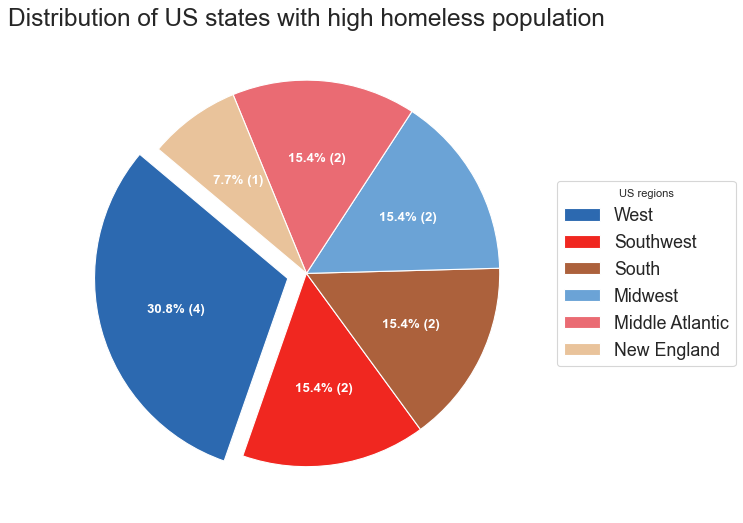

In [248]:
fig, ax = plt.subplots(figsize=(14, 8), 
                       subplot_kw=dict(aspect="equal"), 
                       dpi= 80)

data = which_states["region"].value_counts()
categories = which_states["region"].value_counts().index
explode = [0.1,0,0,0,0,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data,
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"),
                                  colors=palettable.tableau.BlueRed_6.mpl_colors,
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="US regions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=12, weight=700)
ax.set_title("Distribution of US states with high homeless population")
plt.show()

From the last figure, it can be shown the US-region where most high-homeless population states are located in the West region.

### How has changed the homeless population of those states over time?

In order to show the variation over time, let's create a lineplot.

In [249]:
top_states_df = raw_data_df[raw_data_df["State name"].isin(name_top_states)]

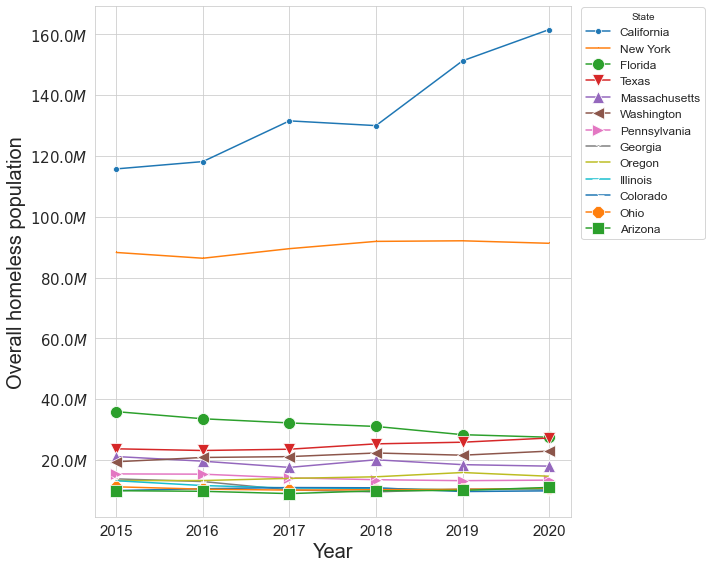

In [250]:
_, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="Year", y="Homeless pop",
                     data=top_states_df[top_states_df["State name"] == state],
                     palette=palettable.tableau.BlueRed_12.mpl_colors,
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

Based on this figure, California (CA) is the state where the homelessness population has increased the most from 2018 to 2020. The New York state (NY) has shown a continuous homelessness increase.

In contrast, Florida (FL) has shown a continuous decrease since 2015. Let's see the behaviour of the rest of the states.

Due the magnitud order, the homeless population for the rest of the states has been shrunk to the plot bottom. Because of that, let's split the graph

In [251]:
out_state = ['California', 'New York', 'Florida']
new_top_states = [i for i in name_top_states if i not in out_state]

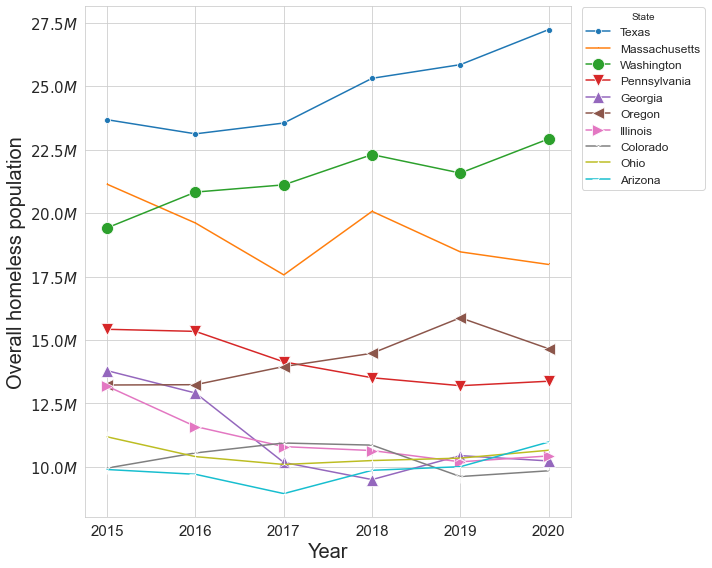

In [252]:
_, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(new_top_states):
    _ = sns.lineplot(x="Year", y="Homeless pop",
                     data=top_states_df[top_states_df["State name"] == state],
                     palette=palettable.tableau.BlueRed_12.mpl_colors,
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Overall homeless population', fontsize=20)
ax.legend(labels=new_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

On the previous graph, it is possible to observe that the homeless population has increased considerably in Texas and Washington states. In contrast, Pennsylvania and  Illinois show that growth slowed down noticeably.
An interesting case is Georgia state, where homelessness has decreased dramatically. Finally, Colorado state shows a steady level, while Ohio appeared on the map in 2019 with a 3%-increase in the homeless population.

## Analyzing the 25 years and over US population

The main project goal is to analyze recent US population data to answer the question: 

**Will a rent cost increment increase the risk of people who have been awarded a degree experiencing homelessness?**

Because of that, in the following section, a comparison between the US 25-year-and-over population is shown.

Let's create a pivot table where the 25 year and over population is summed by year

In [253]:
year25_pt = pd.pivot_table(
    data=indexed_data_df,
    index="Year",
    values=["Pop. 25year+ educ", "Pop. 25year+ no schooling", "Pop. 25year+ bachelor", "Pop. 25year+ master over"],
    aggfunc='sum'
)

In [254]:
year25_pt

,Pop. 25year+ bachelor,Pop. 25year+ educ,Pop. 25year+ master over,Pop. 25year+ no schooling
Year,,,,
2015,41576643,218829689,35944674,3191717
2016,42675515,220847677,37397456,3197250
2017,44013586,223593758,39171256,3238045
2018,45029878,225446877,40358458,3305133
2019,46174068,227200303,41359648,3360924
2020,45478307,225168128,40665846,3513496


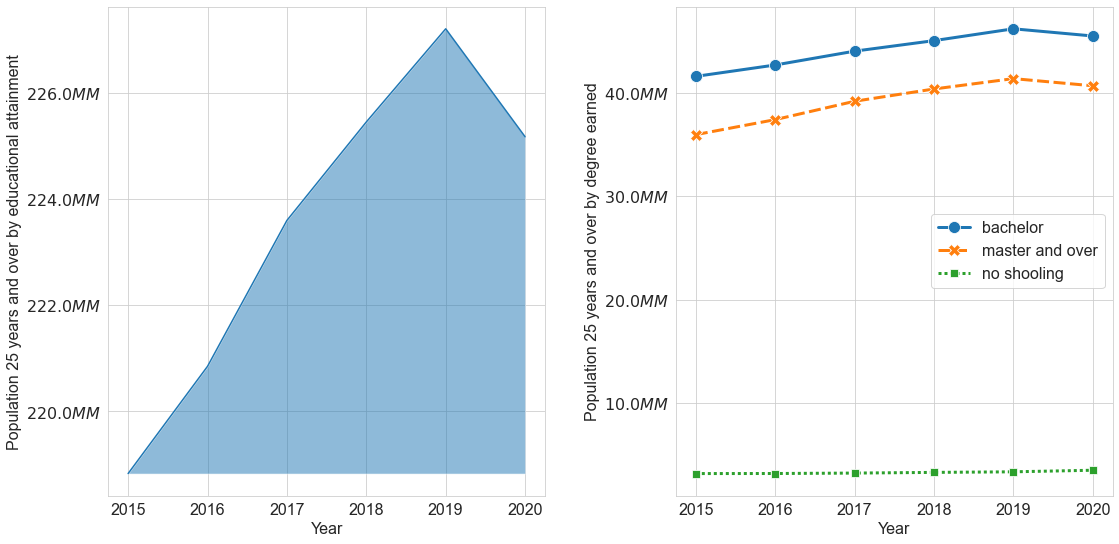

In [255]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
_ = sns.lineplot(x=year25_pt.index,
                 y='Pop. 25year+ educ',
                 data=year25_pt,
                 ax=ax1)
ax1.fill_between(x=year25_pt.index, 
                 y1=year25_pt['Pop. 25year+ educ'].min(), 
                 y2=year25_pt['Pop. 25year+ educ'], alpha=0.5)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax1.set(ylabel="Population 25 years and over by educational attainment")

_ = sns.lineplot(x='Year',
                 y='value',
                 hue='variable',
                 data=pd.melt(year25_pt.drop('Pop. 25year+ educ', axis=1).reset_index(), ["Year"]),
                 ax=ax2,
                 lw=3,
                 markers=True,
                 style='variable', 
                 markersize=12)
ax2.set(ylabel="Population 25 years and over by degree earned")
ax2.legend(labels=['bachelor', 'master and over', 'no shooling'],
           loc='best')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
fig.subplots_adjust(wspace=.3)
plt.show()


From the left plot, the 25-year population who have earned a formal educational level increased by around 4% from 2015 to 2019. However, in 2020, an almost 1% decrease is shown. 

On the left graph, the bachelor's graduate population has kept 30% higher than the master's and above graduates from 2015 to 2020.

Interestingly, the population who haven't finished schooling has risen steadily to 1% of the total 25-year population during the same timespan.

In general, bachelor's graduate population represent a 20% of the population based on educational attainment while the master's one a 15%.

## US Population in labor force and in households

In [256]:
some_population_pt = pd.pivot_table(
    data=indexed_data_df.loc[2017:],
    index="Year",
    values=["Population", "Pop in households", "Pop in labor force", "Bachelor+ in labor force"],
    aggfunc='sum'
)

In [257]:
some_population_pt

,Bachelor+ in labor force,Pop in households,Pop in labor force,Population
Year,,,,
2017,49486843,121254123,165928662,329056355
2018,50702924,122699817,167091685,330362592
2019,51941004,123973834,168719014,331433217
2020,51234055,123559968,167113763,329824950


In [258]:
cmap = palettable.tableau.BlueRed_6.mpl_colormap
years = [2017, 2018, 2019, 2020]

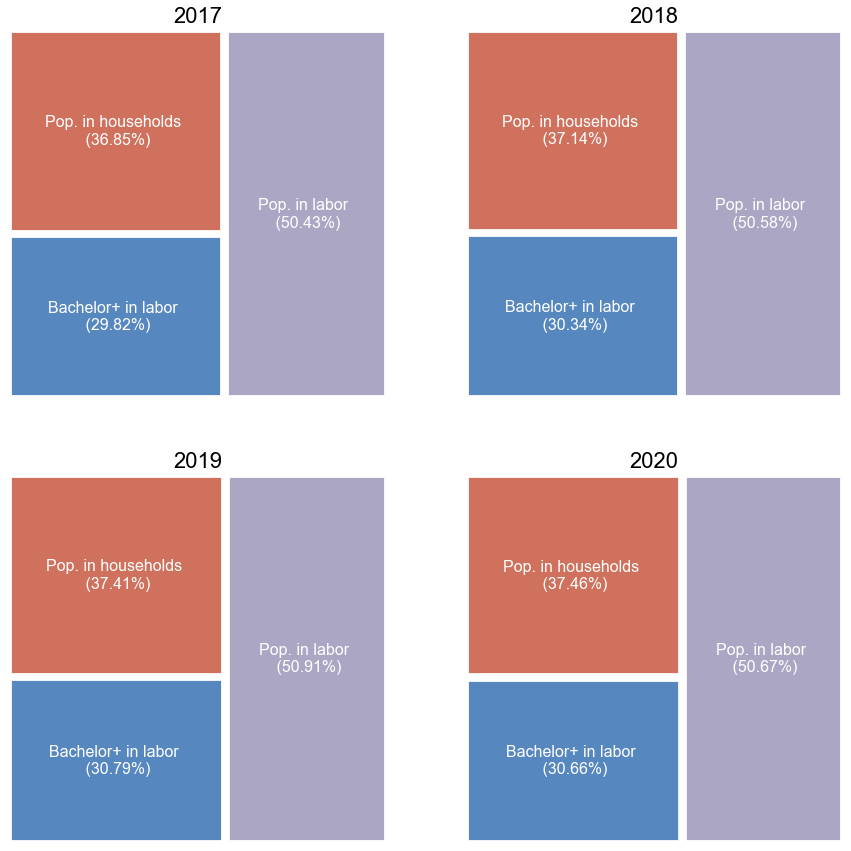

In [259]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
for year, ax in zip(years, axes.ravel()):
    temp_df = some_population_pt.loc[year]
    names = ["Bachelor+ in labor", "Pop. in households", "Pop. in labor"]
    sizes = np.round(np.array([temp_df["Bachelor+ in labor force"]/temp_df["Pop in labor force"],
                               temp_df["Pop in households"]/temp_df["Population"],
                               temp_df["Pop in labor force"]/temp_df["Population"]])*100, 2)
    labels = [n + ' \n (' + str(i) + '%)' for n, i in zip(names, sizes)]
    mapped_list = [cmap(i) for i in np.arange(0, 1, 1/len(sizes))]


    squarify.plot(sizes=sizes,
                  label=labels,
                  color=mapped_list,
                  alpha=.8,
                  pad=True, ax=ax,
                  text_kwargs={'fontsize':16, 'color': 'white'})
    ax.set_title(year, c='black')
    ax.axis("off")
plt.show()

From this plot, the distribution of population in households, in labor and bachelor's graduate have kept almost the same since 2017

## Selection of the US states for further analysis

In order to visualize the relative change between the homeless population and the total population. Let's create the following ratio

$$ \text{ratio} = \frac{\text{Homeless population}}{\text{Total population}}\cdot 100 $$

In [260]:
subdata = top_states_df[["Year", "State name", "Population", "Homeless pop"]].copy()
subdata["% homeless"] = subdata["Homeless pop"] /subdata["Population"] * 100

In [261]:
subdata

,Year,State name,Population,Homeless pop,% homeless
8,2015,New York,19795791,88250,0.445802
11,2015,Ohio,11613423,11182,0.096285
13,2015,Oregon,4028977,13226,0.328272
14,2015,Pennsylvania,12802503,15421,0.120453
19,2015,Texas,27469114,23678,0.086199
...,...,...,...,...,...
283,2020,Massachusetts,6873003,17975,0.261531
284,2020,Texas,28635442,27229,0.095088
287,2020,Ohio,11675275,10655,0.091261
288,2020,Colorado,5684926,9846,0.173195


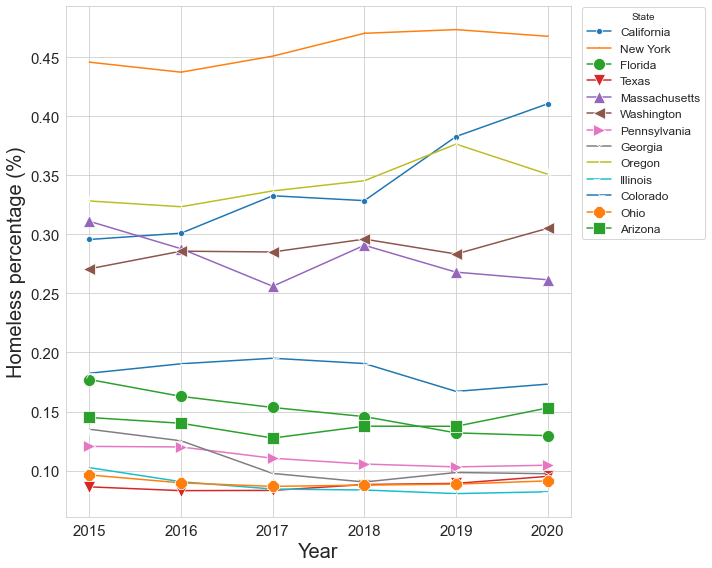

In [262]:
fig, ax = plt.subplots(figsize=(10, 8))
for i, state in enumerate(name_top_states):
    _ = sns.lineplot(x="Year", y="% homeless",
                     data=subdata[subdata["State name"] == state],
                     palette=palettable.tableau.BlueRed_12.mpl_colors,
                     marker=all_shapes[i],
                     markersize=12)

ax.set_ylabel('Homeless percentage (%)', fontsize=20)
ax.legend(labels=name_top_states, title = "State",
          fontsize = 'large',
          bbox_to_anchor=(1.01, 1.01), loc="upper left")
ax.set_xlabel('Year', fontsize=20)
plt.tick_params(which='major', labelsize=15)
plt.tight_layout()
plt.show()

From the graph, New York is the state with the highest proportion of people experiencing  homelessness. Along New York, the states with higher ratio homeless/population are: California, Oregon, Washington and Massachusetts.

On the other hand, Colorado, Florida, Arizona have a lower ratio, while Illinois has the lowest ratio in the group of states.

The group top ratio homeless-population states can be split at 0.25% level.

In [263]:
df1 = subdata[subdata["% homeless"] > 0.25]
df2 = subdata[subdata["% homeless"] < 0.25]

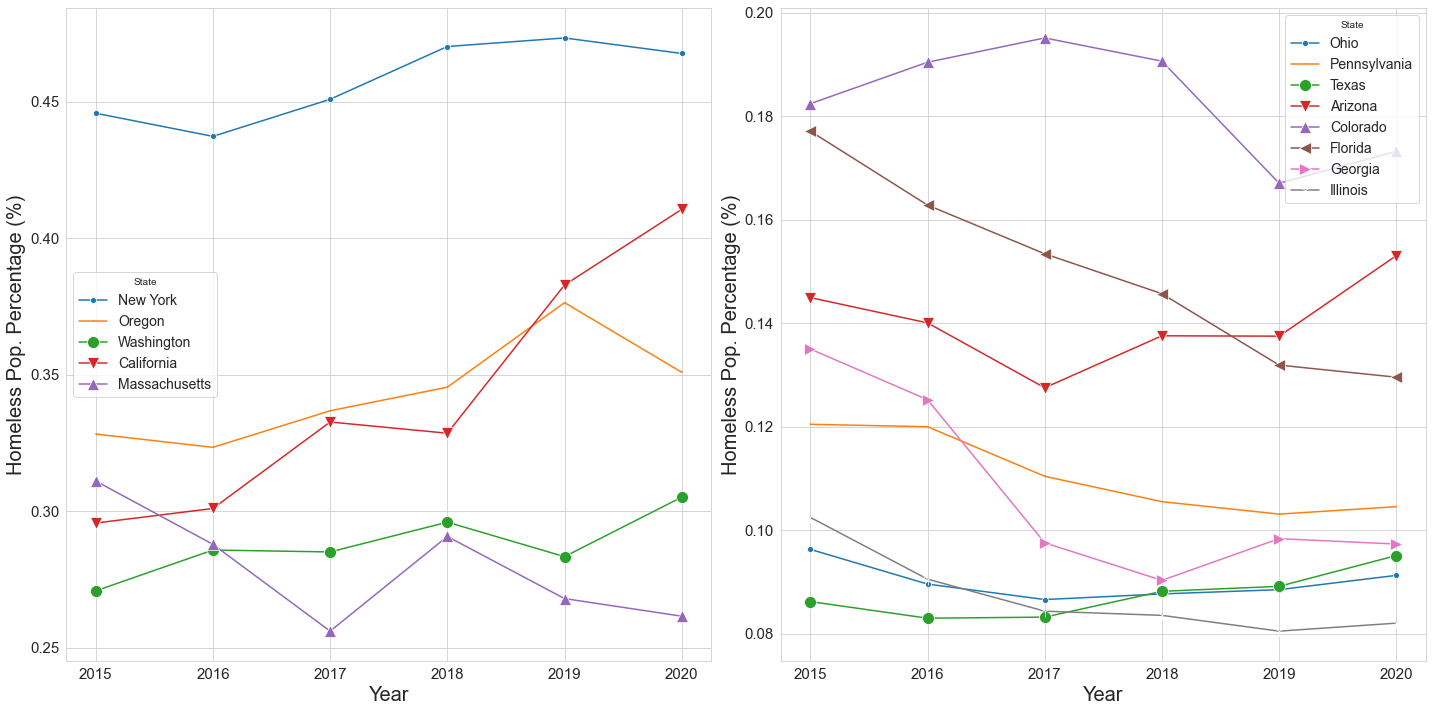

In [264]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
dataframes = [df1, df2]
for dataframe, ax in zip(dataframes, axes.ravel()):
    states = dataframe["State name"].unique().tolist()
    for i, state in enumerate(states):
        _ = sns.lineplot(x="Year", y="% homeless", 
                         data=dataframe[dataframe["State name"] == state],
                         palette=palettable.tableau.BlueRed_6.mpl_colors,
                         marker=all_shapes[i], markersize=12, ax=ax)

    ax.set_ylabel('Homeless Pop. Percentage (%)', fontsize=20)
    ax.legend(labels=states, title = "State",
               fontsize = 14, loc="best")
    ax.set_xlabel('Year', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

These plots are interesting because show which states have had higher variance (change) on the ratio homeless-population in the last 6 years.

Based on those results, a better selection of the states for further study can be done. Let's calculate the mean and std for each feature

In [265]:
subdata.groupby(["State name"])["% homeless"].agg(['mean', 'std']).sort_values(
    by="std", 
    ascending=False)

,mean,std
State name,,
California,0.341894,0.045757
Massachusetts,0.279207,0.020963
Oregon,0.343536,0.019093
Florida,0.150073,0.018300
Georgia,0.107287,0.018175
New York,0.457563,0.014874
Washington,0.287690,0.011720
Colorado,0.183129,0.011054
Arizona,0.140096,0.008513


The selection of states will be those whose std % homeless is higher than 0.011

In [266]:
final_state_list = subdata.groupby(["State name"])["% homeless"].agg('std').sort_values(ascending=False)
list_states = final_state_list[final_state_list.values > 0.011].index.tolist()

In [267]:
list_states

['California',
 'Massachusetts',
 'Oregon',
 'Florida',
 'Georgia',
 'New York',
 'Washington',
 'Colorado']

## Number of renter housing units by educational attainment level

The data was taken from the census.gov and it refers to the number of housing units available for rent, and the amount of occupied by people based on their educational level.

Therefore, the total of units by state represents the total number of renter housing units occupied by people based on their instructional level.

In [268]:
query = ("SELECT "
         "year, "
         "name_state, "
         "total_renter_occupied_units_educ_attainment, "
         "renter_occupied_units_high_school_graduate, "
         "renter_occupied_units_some_college_degree, "
         "renter_occupied_units_bachelor_degree_or_higher "
         "FROM us_population "
         "WHERE name_state IN ('" + "', '".join(list_states) + "')")

In [269]:
renter_occupied_df = cheroku.make_query(query, "c1_capstone",credential_file )

In [270]:
renter_occupied_df.rename(
    {'year': 'Year',
     'name_state': 'State name',
     'total_renter_occupied_units_educ_attainment': 'Total occupied units',
     'renter_occupied_units_high_school_graduate': 'HS graduate', # High School graduate
     'renter_occupied_units_some_college_degree' :'College degree',
     'renter_occupied_units_bachelor_degree_or_higher' : 'Bachelor degree or higher'}, axis='columns', inplace=True)

### Percentage of the units occupied by Bachelors or above. 

In [271]:
renter_occupied_df["Perc bachelor or higher"] = renter_occupied_df["Bachelor degree or higher"] / renter_occupied_df["Total occupied units"] * 100

renter_occupied_df.set_index(["Year", "State name"], inplace=True)

In [272]:
renter_occupied_df

Total occupied units  HS graduate  College degree  \
Year State name                                                         
2015 New York                    3394792       844820          845166   
     Oregon                       604314       134547          240163   
     Washington                  1025304       230928          383616   
     California                  5985534      1200022         1893017   
     Colorado                     752117       159916          272185   
     Florida                     2703113       746895          905205   
     Georgia                     1395241       381047          462321   
     Massachusetts                979998       256051          256315   
2016 New York                    3367884       842587          832435   
     Oregon                       602099       134741          232715   
     Washington                  1038756       228848          382716   
     California                  6000750      1172516         1895661   
     Colorado                     743160       169862          264391   
     Florida                     2716331       756690          897648   
     Georgia                     1417529       374613          460669   
     Massachusetts                980468       255927          247469   
2017 New York                    3374299       868719          822243   
     Oregon                       596620       138924          227762   
     Washington                  1056828       234076          393582   
     California                  5880007      1167700         1835573   
     Colorado                     744383       162841          262026   
     Florida                     2679777       758775          893171   
     Georgia                     1390152       394684          444283   
     Massachusetts                981439       267497          244481   
2018 New York                    3413230       863831          822469   
     Oregon                       615117       139189          230828   
     Washington                  1076587       234401          390863   
     California                  5906458      1203884         1823407   
     Colorado                     758776       158898          264440   
     Florida                     2661116       738646          860756   
     Georgia                     1376577       384552          438661   
     Massachusetts               1003582       243505          254588   
2019 New York                    3461296       875810          834760   
     Oregon                       612227       139477          235822   
     Washington                  1082785       232286          395085   
     Georgia                     1382142       364332          451772   
     Massachusetts               1002933       248245          245302   
     Florida                     2668313       735931          861242   
     California                  5939131      1170712         1795291   
     Colorado                     763191       167779          257594   
2020 California                  5861796      1139471         1819433   
     New York                    3402708       836585          835974   
     Florida                     2680435       734536          875359   
     Georgia                     1377105       370881          451423   
     Oregon                       611573       135147          232841   
     Massachusetts                992088       247804          249190   
     Colorado                     722078       155657          251821   
     Washington                  1067763       229626          391055   

                    Bachelor degree or higher  Perc bachelor or higher  
Year State name                                                         
2015 New York                         1100677                32.422517  
     Oregon                            161900                26.790708  
     Washington                        302918                29.544213  
    

Pivot Table for aggregating the percentage of occupied houses by Bachelors or above

In [273]:
perc_renter_unit_by_bachelor_or_higher = (renter_occupied_df.pivot_table(index="State name",
                                                                         columns="Year", 
                                                                         values="Perc bachelor or higher").round(2))

In [274]:
perc_renter_unit_by_bachelor_or_higher = perc_renter_unit_by_bachelor_or_higher.transpose()

In [275]:
perc_renter_unit_by_bachelor_or_higher

State name,California,Colorado,Florida,Georgia,Massachusetts,New York,Oregon,Washington
Year,,,,,,,,
2015,29.14,31.62,25.01,23.43,33.10,32.42,26.79,29.54
2016,29.95,31.16,25.11,25.34,33.59,32.53,27.62,30.21
2017,30.93,32.82,25.01,24.60,34.08,32.75,27.56,30.44
2018,31.28,33.89,27.12,25.55,36.35,33.50,28.67,31.98
2019,32.64,35.35,27.21,26.87,37.79,34.94,29.36,32.41
2020,32.31,34.15,27.11,26.41,36.67,34.59,29.59,32.10


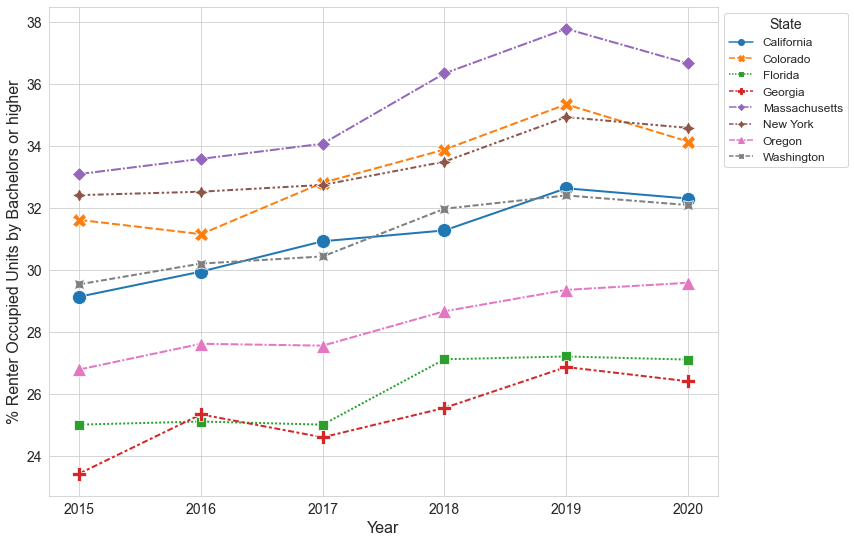

In [276]:

fig, ax = plt.subplots(figsize=(12, 9))
g = sns.lineplot(data=perc_renter_unit_by_bachelor_or_higher,
                 palette=palettable.tableau.Tableau_10.mpl_colors[:8],
                 ax=ax, markers=True, markersize=14, lw=2)
ax.set(ylabel="% Renter Occupied Units by Bachelors or higher", 
              xlabel="Year")
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(loc=2, bbox_to_anchor= (1,1),
           title="State", fontsize=12, title_fontsize=14)
plt.show()

## Takeaways:
From there, we can say:
- From 2015 to 2020, bachelor's or above has rented between 22% to 35% of the rental housing market in the selected states.
- Oregon had shown around 2%-increment in houses rented by bachelors or above between 2017 and 2020. In contrast, it was about a 1%-decrease between 2019 and 2020 is shown in Massachusetts and Colorado.
- For the rest of the states, the rental rate is slowing down.

## Median income of bachelors or above 
In this section, the features related to income and gross rent cost are analyzed focusing on professional householders. 

In [277]:
query = ("SELECT year, name_state, "
         " median_earnings_bachelor, "
         " median_earnings_master_or_above, "
         " median_gross_rent "
         " FROM us_population "
         " WHERE name_state IN ('" + "', '".join(list_states) + "')")
earning_df = cheroku.make_query(query, "c1_capstone", credential_file)

In [278]:
earning_df.rename({
    "year": "Year",
    "name_state": "State name",
    "median_earnings_bachelor": "Bachelor earning",
    "median_earnings_master_or_above": "Master or above earning",
    "median_gross_rent": "Gross rent"
}, axis=1, inplace=True)

What is the average national of the income for a bachelor and master graduates?

The next pivot table will help to answer that question

In [279]:
average_income_pt = pd.pivot_table(
    data=earning_df,
    values=["Bachelor earning", "Master or above earning"],
    index="Year")

In [280]:
average_income_pt

,Bachelor earning,Master or above earning
Year,,
2015,51547.125,67579.250
2016,53728.125,69625.250
2017,55125.375,71916.625
2018,56791.125,74543.375
2019,58474.500,77522.625
2020,58469.625,76875.375


From the previous results, the average of the median income had been increased yearly from 2015 to 2019 for both professional groups. However, from 2019 to 2020 their income decreased by 5% approx.

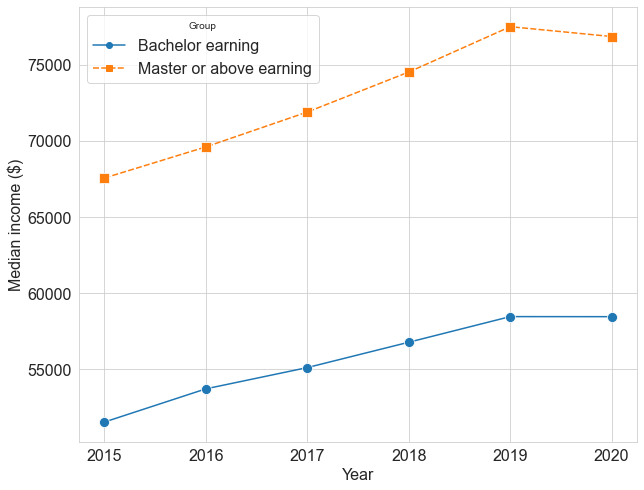

In [281]:
fig, ax = plt.subplots(figsize=(10, 8))
_ = sns.lineplot(x="Year",
                 hue="variable",
                 y="value",
                 data=pd.melt(average_income_pt.reset_index(), ['Year']),
                 markers=['o', 's'],
                 markersize=10,
                 style="variable")
ax.set(xlabel="Year", ylabel="Median income ($)")
ax.legend(title='Group', loc='best')
plt.show()

What it would be maximum rent cost a graduate professional could afford?

For this estimation, let's assume a professional will have to pay 37% in taxes and a mandatory requirement is that his/her monthly income has to twice higher than the rent cost offered.

$$ \text{max rent cost} = \text{salary}\, \left(\frac{100 - \text{\% taxes}}{12 \cdot \text{ratio} \cdot 100}\right) $$

In [282]:
def max_rent(value, tax_perc=37, ratio=3):
    """
    Calculation of the maximum rent cost based on the income
    Args:
        value (_type_): salary yearly
        tax_perc (int, optional): _description_. Defaults to 37.
        ratio (int, optional): _description_. Defaults to 3.

    Returns:
        _type_: maximum rent cost 
    """
    return np.round(value * (100 - tax_perc) / 12 / ratio / 100, 2)

In [283]:
# Some calculations
tax_percentage = 37
ratio_rent_income = 3
earning_df["Perc diff"] = (((earning_df["Master or above earning"] -
                             earning_df["Bachelor earning"]) / earning_df["Bachelor earning"] * 100).round(2))

earning_df["Max rent Bachelor"] = earning_df["Bachelor earning"].apply(lambda x: max_rent(x,tax_percentage, ratio_rent_income))
earning_df["Max rent Master"] = earning_df["Master or above earning"].apply(lambda x: max_rent(x,tax_percentage, ratio_rent_income))

In [284]:
earning_df.head(10)

,Year,State name,Bachelor earning,Master or above earning,Gross rent,Perc diff,Max rent Bachelor,Max rent Master
0,2015,New York,55360,71684,1173,29.49,968.80,1254.47
1,2015,Oregon,44049,61139,943,38.80,770.86,1069.93
2,2015,Washington,55795,71123,1080,27.47,976.41,1244.65
3,2015,California,57282,80442,1311,40.43,1002.44,1407.74
4,2015,Colorado,50196,63270,1111,26.05,878.43,1107.22
5,2015,Florida,42714,57128,1046,33.75,747.50,999.74
6,2015,Georgia,49696,61443,909,23.64,869.68,1075.25
7,2015,Massachusetts,57285,74405,1164,29.89,1002.49,1302.09
8,2016,New York,56868,73504,1194,29.25,995.19,1286.32
9,2016,Oregon,46942,63868,1015,36.06,821.48,1117.69


**How much a master professional earns over a bachelor one?**

In [285]:
pd.pivot_table(data=earning_df,
               index="State name",
               columns="Year",
               values="Perc diff",
               margins=True).round(2)

Year,2015,2016,2017,2018,2019,2020,All
State name,,,,,,,
California,40.43,36.84,40.39,44.68,41.88,41.93,41.02
Colorado,26.05,28.40,29.73,24.11,22.99,28.08,26.56
Florida,33.75,32.30,33.53,33.13,30.57,31.32,32.43
Georgia,23.64,23.27,26.13,23.19,30.50,27.31,25.67
Massachusetts,29.89,27.22,28.67,31.08,31.12,29.47,29.58
New York,29.49,29.25,24.96,27.03,29.25,28.61,28.10
Oregon,38.80,36.06,32.56,34.20,34.97,33.29,34.98
Washington,27.47,24.15,28.07,31.71,37.98,30.95,30.05
All,31.19,29.69,30.51,31.14,32.41,31.37,31.05


A Master's degree holder earns an average of 30% more than a bachelor graduate in the last 6 years. In California, a master graduate earns 40% over a bachelor professional, while in Georgia is only 25% more.

**How much the gross rent has change over time?**

In [286]:
pd.pivot_table(data=earning_df,
               index="State name",
               columns="Year",
               values="Gross rent",
               margins=True).round(2)

Year,2015,2016,2017,2018,2019,2020,All
State name,,,,,,,
California,1311.00,1375,1447.00,1520.00,1614.00,1586.00,1475.50
Colorado,1111.00,1171,1240.00,1289.00,1369.00,1335.00,1252.50
Florida,1046.00,1086,1128.00,1182.00,1238.00,1218.00,1149.67
Georgia,909.00,933,958.00,1008.00,1049.00,1042.00,983.17
Massachusetts,1164.00,1179,1208.00,1295.00,1360.00,1336.00,1257.00
New York,1173.00,1194,1226.00,1274.00,1309.00,1315.00,1248.50
Oregon,943.00,1015,1079.00,1130.00,1185.00,1173.00,1087.50
Washington,1080.00,1135,1216.00,1316.00,1359.00,1337.00,1240.50
All,1092.12,1136,1187.75,1251.75,1310.38,1292.75,1211.79


The average gross rent cost in the selected states had had a constant increase between 2015 to 2019. Nevertheless, in 2020 showed a slightly decrease.

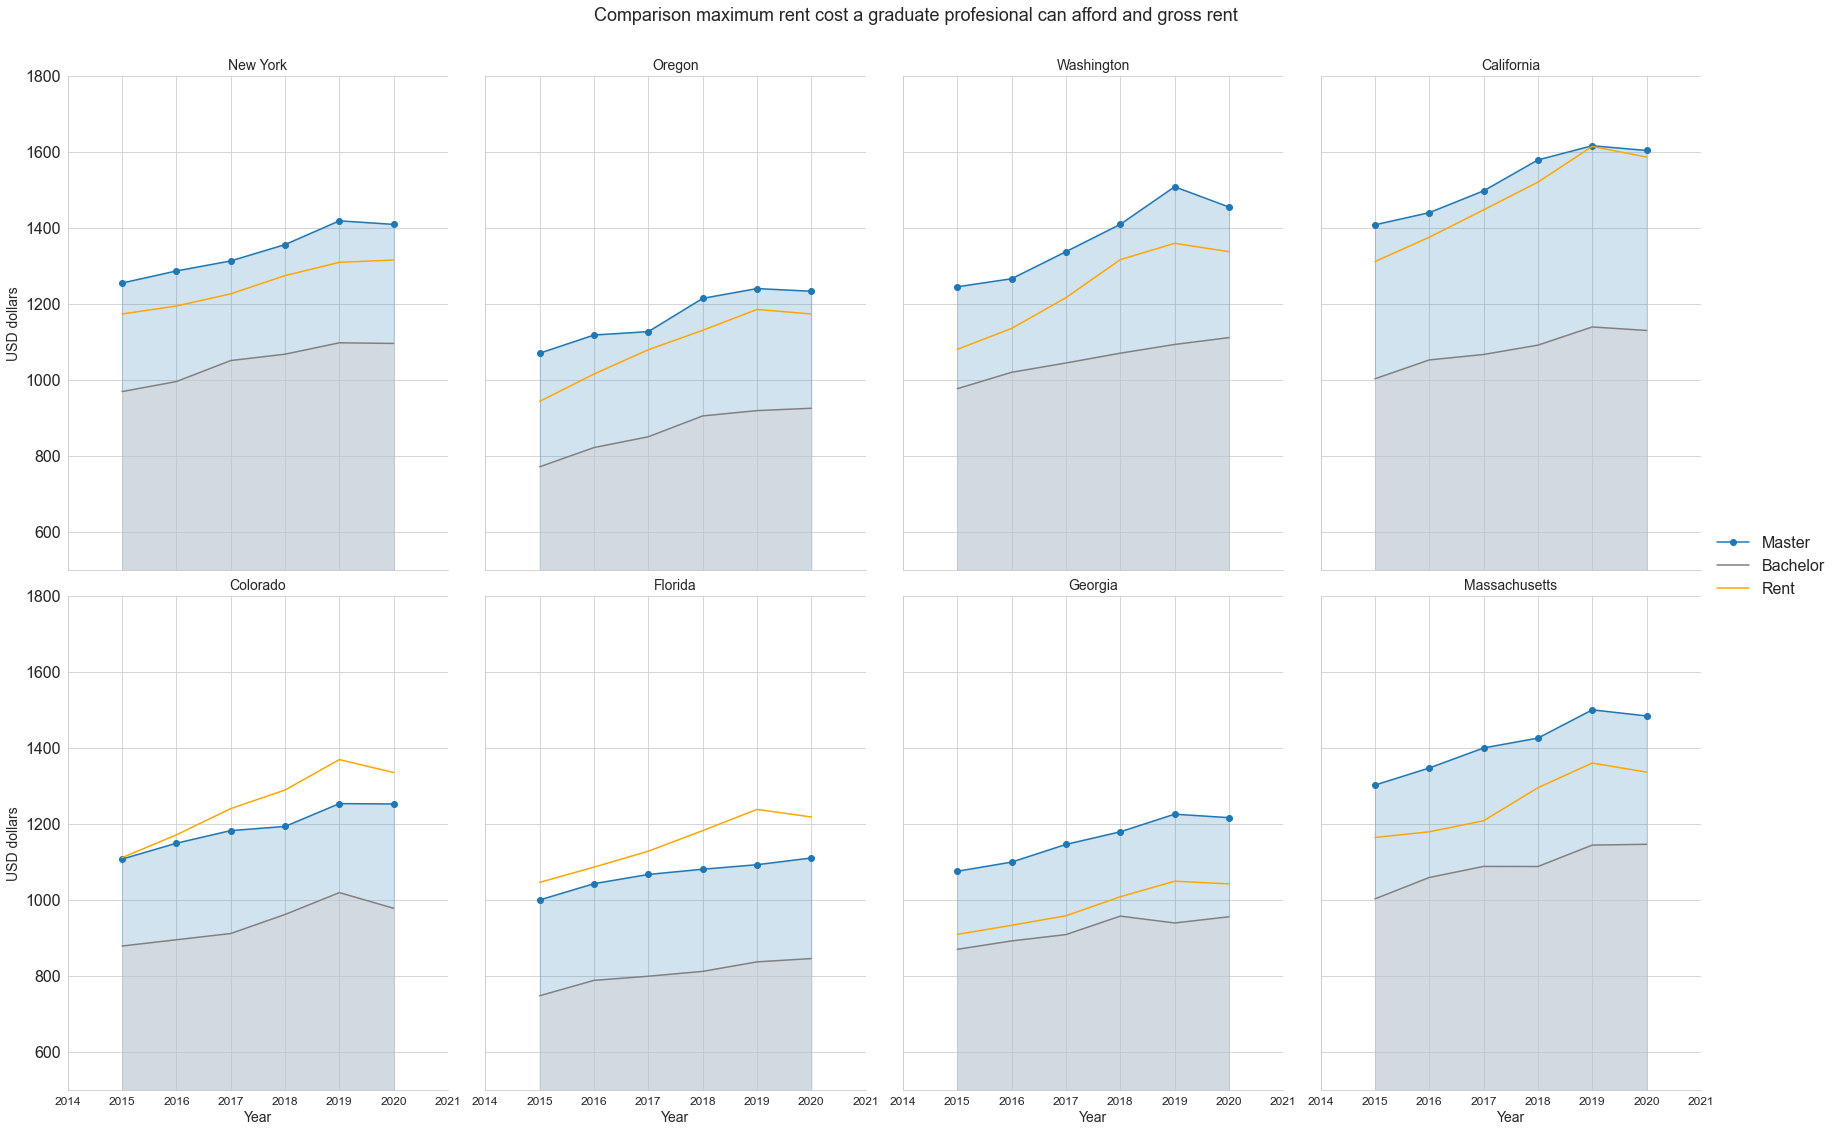

In [287]:
g = sns.FacetGrid(earning_df, 
                  col='State name', 
                  col_wrap=4, height=8, aspect=.75, ylim=(500, 1800))
g = g.map(plt.plot, 'Year', 'Max rent Master', label="Master", marker='o')
g = g.map(plt.plot, 'Year', 'Max rent Bachelor', color='gray', label="Bachelor")
g = g.map(plt.plot, 'Year', 'Gross rent', color='orange', label="Rent")
g = g.map(plt.fill_between, 'Year', 'Max rent Master', alpha=0.2)
g = g.map(plt.fill_between, 'Year', 'Max rent Bachelor', color='lightgray', alpha=0.5)
g = g.set_ylabels("USD dollars", fontsize=14)
g = g.set_xlabels("Year", fontsize=14)
g = g.set_titles("{col_name}", size=14)
g = g.set_xticklabels(fontsize=12)

g.tight_layout()
g.add_legend()
plt.subplots_adjust(top=0.92)
g = g.fig.suptitle('Comparison maximum rent cost a graduate profesional can afford and gross rent', fontsize=18)
# Show the graph
plt.show()

This figure is fascinating. It is shown that the median income for a bachelor's graduate is not enough to rent a house in none of the selected US-States. Florida is the only state where a bachelor's graduate roughly can afford the median gross rental cost. 

In contrast, a master's graduate should be able to afford the median gross rent in all the states except Colorado and Florida. 

Another thing is the gross rent cost has been increasing steadily in all States. California shows a 25%-increment percentage around %25, which is the higher observed among the selected States. On the other hand, the gross rent cost showed a slight decrease between 2019 and 2020

What is the maximum rent increase a master graduate could be tolerated?

Assuming the rent cost and median earning for master graduated kept constant. What it would be the maximum rental cost increase that can be afford for that population sector?

In [288]:
def able_to_pay(gross_rent, max_rent):
    if max_rent >= gross_rent:
        max_increase = round((max_rent/gross_rent - 1) * 100, 2)
    else:
        max_increase = 0
    return max_increase

In [289]:
subdata = earning_df.copy()
subdata.set_index(["Year", "State name"], inplace=True)

In [290]:
subdata2020 = subdata.loc[(2020, slice(None))]
subdata2020.reset_index(inplace=True)
subdata2020 = subdata2020.drop(["Bachelor earning", "Perc diff", "Max rent Bachelor"], axis=1)

In [291]:
subdata2020["Max increase Master"] = subdata2020[["Gross rent", "Max rent Master"]].apply(lambda x:able_to_pay(*x), axis=1)
subdata2020.sort_values(by="Max increase Master", ascending=False, inplace=True)

In [292]:
subdata2020

,State name,Master or above earning,Gross rent,Max rent Master,Max increase Master
3,Georgia,69501,1042,1216.27,16.72
5,Massachusetts,84800,1336,1484.00,11.08
7,Washington,83120,1337,1454.60,8.80
1,New York,80506,1315,1408.86,7.14
4,Oregon,70453,1173,1232.93,5.11
0,California,91622,1586,1603.38,1.10
2,Florida,63440,1218,1110.20,0.00
6,Colorado,71561,1335,1252.32,0.00


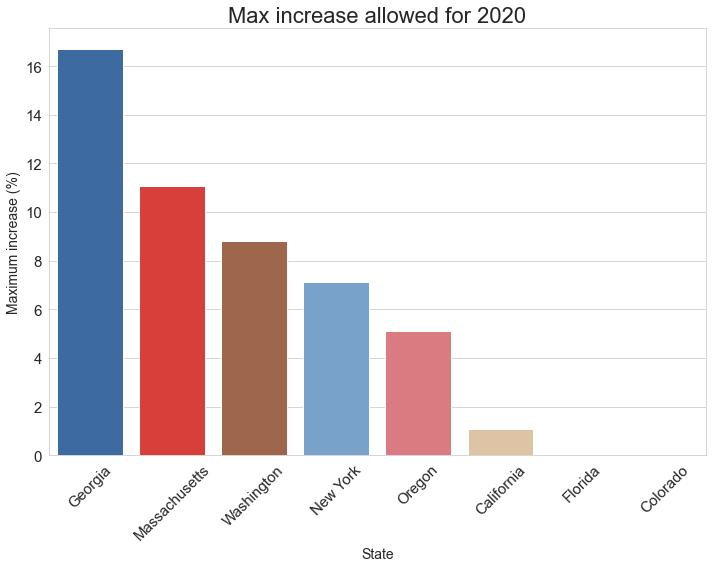

In [293]:
fig, ax = plt.subplots(figsize=(10, 8))
g = sns.barplot(y="Max increase Master", 
                x="State name", 
                data=subdata2020,
                palette=palettable.tableau.BlueRed_6.mpl_colors, ax=ax)
g.set_ylabel("Maximum increase (%)", fontsize=14)
g.set_xlabel("State", fontsize=14)
g.set_title("Max increase allowed for 2020")
g.tick_params(axis='both', which='major', labelsize=15)
g.tick_params(axis="x", labelrotation=45)
plt.tight_layout()
plt.show()

## Distribution of renter housing units by income salary

Assuming the rent cost increases higher than the maximum a master graduate can afford, are there cheaper rental options?

Based on our last result, let's focus on Georgia, Massachusetts, Washington, New York and California

list_states = ['Georgia', 'Massachusetts', 'Washington', 'New York', 'California']

In [294]:
query = ("SELECT * FROM rent_occupied_by_income "
         " WHERE name_state IN ('" + "','".join(list_states)  + "')")
housing_df = cheroku.make_query(query, "c1_capstone", credential_file)

In [295]:
housing_df = housing_df.drop('id', axis=1)

In [296]:
housing_df.rename({
    'year' : 'Year', 
    'name_state': 'State name', 
    'less_than_r5000': 'Less than $5000',
    'r5000_to_r9999' : '$5000-$9999',
    'r10000_to_r14999' : '$10000-$14999', 
    'r15000_to_r19999' :'$15000-$19999', 
    'r20000_to_r24999' : '$20000-$24999',
    'r25000_to_r34999' : '$25000-$34999', 
    'r35000_to_r49999' : '$35000-$49999', 
    'r50000_to_r74999' : '$50000-$74999',
    'r75000_to_r99999' : '$75000-$99999', 
    'r100000_to_r149999' : '$100000-$149999', 
    'r150000_or_more' : '$150000 or more'
}, axis=1, inplace=True)

In [297]:
housing_df = housing_df.sort_values(by=["Year", "State name"])
housing_df.set_index(["Year", "State name"], inplace=True)

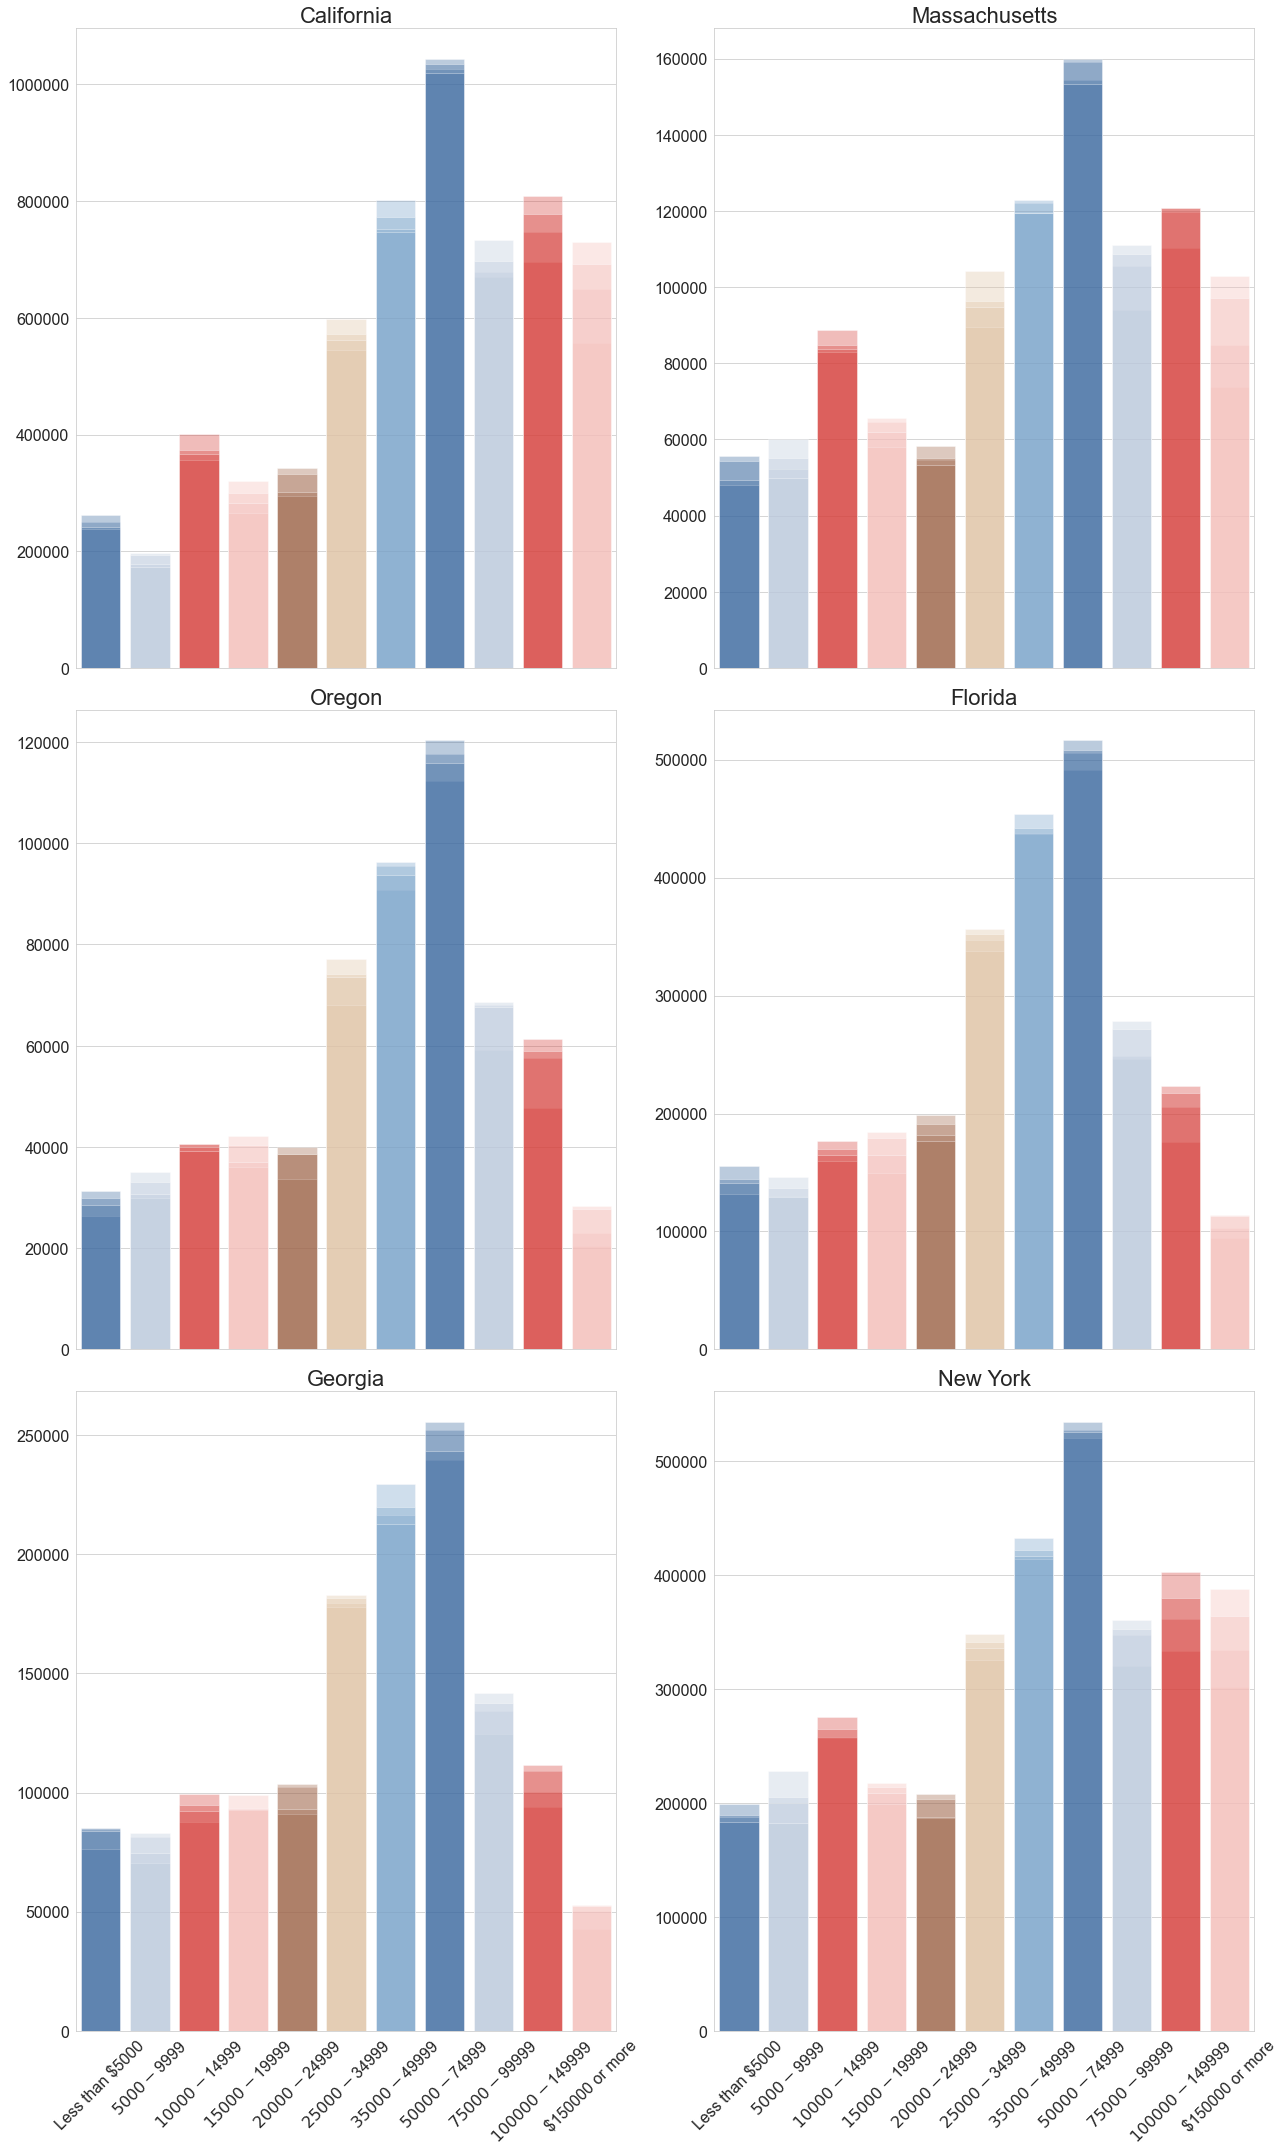

In [298]:
# Create the figure
_, axes = plt.subplots(3, 2, figsize=(18,30), sharex='col')

for state, ax in zip(list_states, axes.ravel()):
    # The data has to be reformated for the barplot seaborn
    subdata = housing_df.loc(axis=0)[:, state]
    subdata.reset_index(inplace=True)
    subdata = subdata.drop(["id_state", "State name"], axis=1)
    subdata = subdata.T
    subdata.columns = subdata.iloc[0]
    subdata = subdata.drop("Year", axis=0)

    for year in years:
        g = sns.barplot(x=subdata.index, y=subdata[year].values,
                        palette = palettable.tableau.BlueRed_12.mpl_colors[:7],
                        ax=ax, alpha=0.35)
        g.set_title(state)
        g.tick_params(labelrotation=45, axis='x')
        g.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

The average income for a master's graduate is $75,000 which belongs to range where there are more renter housing units available in the selected states. Below the income range $50,000 to $74,999 most of the available housing units are rented by people who earn between $25,000 to $50,000. 

Therefore, it seems more likely in case of the rent cost increase more than maximum allowed that group of people could find cheaper places.

Based on the figure, the distribution of rented housing is not the same for all states. However, most units are rented by household income between USD 50,000 and 74,999.
Interestingly, the distribution of rented units for household income of USD 35,000 or above in California and New York tends to be uniform. On the other hand, for income range of USD 25,000 or less, the distribution of housing units is almost uniform.

Finally, in California, New York, and Massachusetts, the proportion of rented housing units with an income of USD 150,000 or above is significantly higher than in the rest of the seleted US States.

Let's check is the number of houses rented by people who earn less money than a master's graduate has increased since 2019

In [299]:
housing_df.reset_index(inplace=True)

In [300]:
subdata = housing_df[(housing_df["Year"] == 2019) | (housing_df["Year"] == 2020)].iloc[:, [0, 1, 7, 8, 9]]
pd.pivot_table(data=subdata,
               index="State name",
               columns="Year")

$25000-$34999         $35000-$49999         $50000-$74999  \
Year                   2019    2020          2019    2020          2019   
State name                                                                
California           545487  562032        751801  747735       1035274   
Colorado              73011   77651        110697  107303        160864   
Florida              337616  352222        438067  442012        516471   
Georgia              178083  181628        219840  212870        255701   
Massachusetts         89652   94697        119355  119366        159921   
New York             325378  335882        414625  417316        534883   
Oregon                68084   73620         96298   93765        120352   
Washington           102914  105126        153085  154729        202341   

                        
Year              2020  
State name              
California     1019318  
Colorado        147626  
Florida         508067  
Georgia         243544  
Massachusetts   153367  
New York        526163  
Oregon          115913  
Washington      202831

The Pivot table shows that the number of rented units increased for the USD 25,000-350000 income range, while for the USD 50,000 to 75,000 range decreased.

At this point, it seems there will have cheaper houses available for renting

## Distribution of renter housing units by rent cost

In [301]:
query = ("SELECT * FROM gross_rent "
         " WHERE name_state IN ('" + "','".join(list_states)  + "')")

In [302]:
gross_rent_df = cheroku.make_query(query,
                                   "c1_capstone",
                                   credential_file)

In [303]:
gross_rent_df = gross_rent_df.drop("id", axis=1)
gross_rent_df.rename({
    'year': 'Year',
    'name_state': 'State name',
    'less_than_100': 'Less than 100',
    'r100_to_r149' : '$100-$149',
    'r150_to_r199' : '$150-$199',
    'r200_to_r249' : '$200-$249',
    'r250_to_r299' : '$250-$299',
    'r300_to_r349' : '$300-$349',
    'r350_to_r399' : '$350-$399',
    'r400_to_r449' : '$400-$449',
    'r450_to_r499' : '$450-$449',
    'r500_to_r549' : '$500-$549',
    'r550_to_r599' : '$550-$599',
    'r600_to_r649' : '$600-$649',
    'r650_to_r699' : '$650-$699',
    'r700_to_r749' : '$700-$749',
    'r750_to_r799' : '$750-$799',
    'r800_to_r899' : '$800-$899',
    'r900_to_r999' : '$900-$999',
    'r1000_to_r1249' : '$1000-$1249',
    'r1250_to_r1499' : '$1250-$1499',
    'r1500_to_r1999' : '$1500-$1999',
    'r2000_to_r2499' : '$2000-$2499',
    'r2500_to_r2999' : '$2500-$2999',
    'r3000_to_r3499' : '$3000-$3499',
    'r3500_to_more' : '$3500 or more'
}, axis='columns', inplace=True)

In [304]:
gross_rent_df.head()

,Year,State name,Less than 100,$100-$149,$150-$199,$200-$249,$250-$299,$300-$349,$350-$399,$400-$449,...,$800-$899,$900-$999,$1000-$1249,$1250-$1499,$1500-$1999,$2000-$2499,$2500-$2999,$3000-$3499,$3500 or more,id_state
0,2015,New York,7166,10928,19334,75748,61802,51727,50293,52649,...,200690,207601,518411,442533,546433,229092,117541,72060,65347,36
1,2015,Oregon,1217,1764,4135,8490,5652,5137,5589,9448,...,68147,65774,113914,60251,53955,14396,4407,2519,1667,41
2,2015,Washington,2662,3985,5918,16466,9906,9940,11834,11794,...,84372,90124,178693,143812,151320,47381,15203,7876,5219,53
3,2015,California,8966,9636,14664,39713,64298,45813,36758,50098,...,369169,411913,980599,885260,1186872,573041,263003,121438,82590,6
4,2015,Colorado,2594,2570,3090,11771,6278,3827,6440,7382,...,60414,64189,142587,116160,115197,34901,9451,4011,4792,8


In [305]:
gross_rent_df = gross_rent_df.sort_values(by=["Year", "State name"])
gross_rent_df.set_index(["Year", "State name"], inplace=True)

In [306]:
gross_rent_df

Less than 100  $100-$149  $150-$199  $200-$249  $250-$299  \
Year State name                                                                 
2015 California              8966       9636      14664      39713      64298   
     Colorado                2594       2570       3090      11771       6278   
     Florida                 3166       4898      13553      25641      19440   
     Georgia                 1383       3167       8789      17889      17513   
     Massachusetts           5941       5641       7505      22932      26360   
     New York                7166      10928      19334      75748      61802   
     Oregon                  1217       1764       4135       8490       5652   
     Washington              2662       3985       5918      16466       9906   
2016 California             13093       7938      12554      34644      67886   
     Colorado                2330       1910       3090       8790       5669   
     Florida                 3622       5089      14625      24276      20923   
     Georgia                 3120       4197       9482      16273      14384   
     Massachusetts           3937       4729       8977      25135      27091   
     New York                6276       7381      18429      77562      57835   
     Oregon                   664       1031       3817       7797       4542   
     Washington              1489       2618       4436      15965      10495   
2017 California              9168       8297      13556      32030      68632   
     Colorado                2282       1066       2434      11746       5397   
     Florida                 3147       4933      11812      27775      17605   
     Georgia                 1812       5065       8930      19038      15123   
     Massachusetts           4768       6282       6178      24233      25686   
     New York                5600       8020      18055      85064      56882   
     Oregon                   646       1392       3093       6775       4318   
     Washington              2802       1943       5535      15128       9642   
2018 California              9375       6599      10145      32886      68943   
     Colorado                3147       1431       3413      10885       7761   
     Florida                 3190       3079      12705      23588      20373   
     Georgia                 3567       3927       9005      14968      15021   
     Massachusetts           4878       5708       5948      19070      29480   
     New York                4850       9061      17679      77901      59234   
     Oregon                  1109       1250       2687       9319       5852   
     Washington              2229       1360       5107      12852       7820   
2019 California              8841       9856      10284      25581      76093   
     Colorado                1933       1083       2021       9015       6615   
     Florida                 2594       2845       9914      28478      18051   
     Georgia                 1980       3820       6402      17147      13725   
     Massachusetts           2857       5237       6844      18257      30299   
     New York                4710      10406      18684      69770      71247   
     Oregon                  1066        993       3816       7464       5792   
     Washington              2617        939       7198      16305       9769   
2020 California              9376       7595      10155      22394      67290   
     Colorado                1909       1272       1863       8600       6163   
     Florida                 2576       3135       9967      25256      16664   
     Georgia                 2264       3112       6679      15355      14040   
     Massachusetts           3808       5051       5282      16060      30742   
     New York                5585       7620      14953      58323      69795   
     Oregon                   747       1147       2413       7134       4797   
     Washington              2004       1633       

### Visualization of distribution of renter housing units

A Barplot is requiered a categorical variable on the x-axis, in our case, gross rent prices range. On the y-axis, a numerical value is needed which it will be the number of housing units.

The next figure shows a set of 6 barplots (one for each year) for each state.

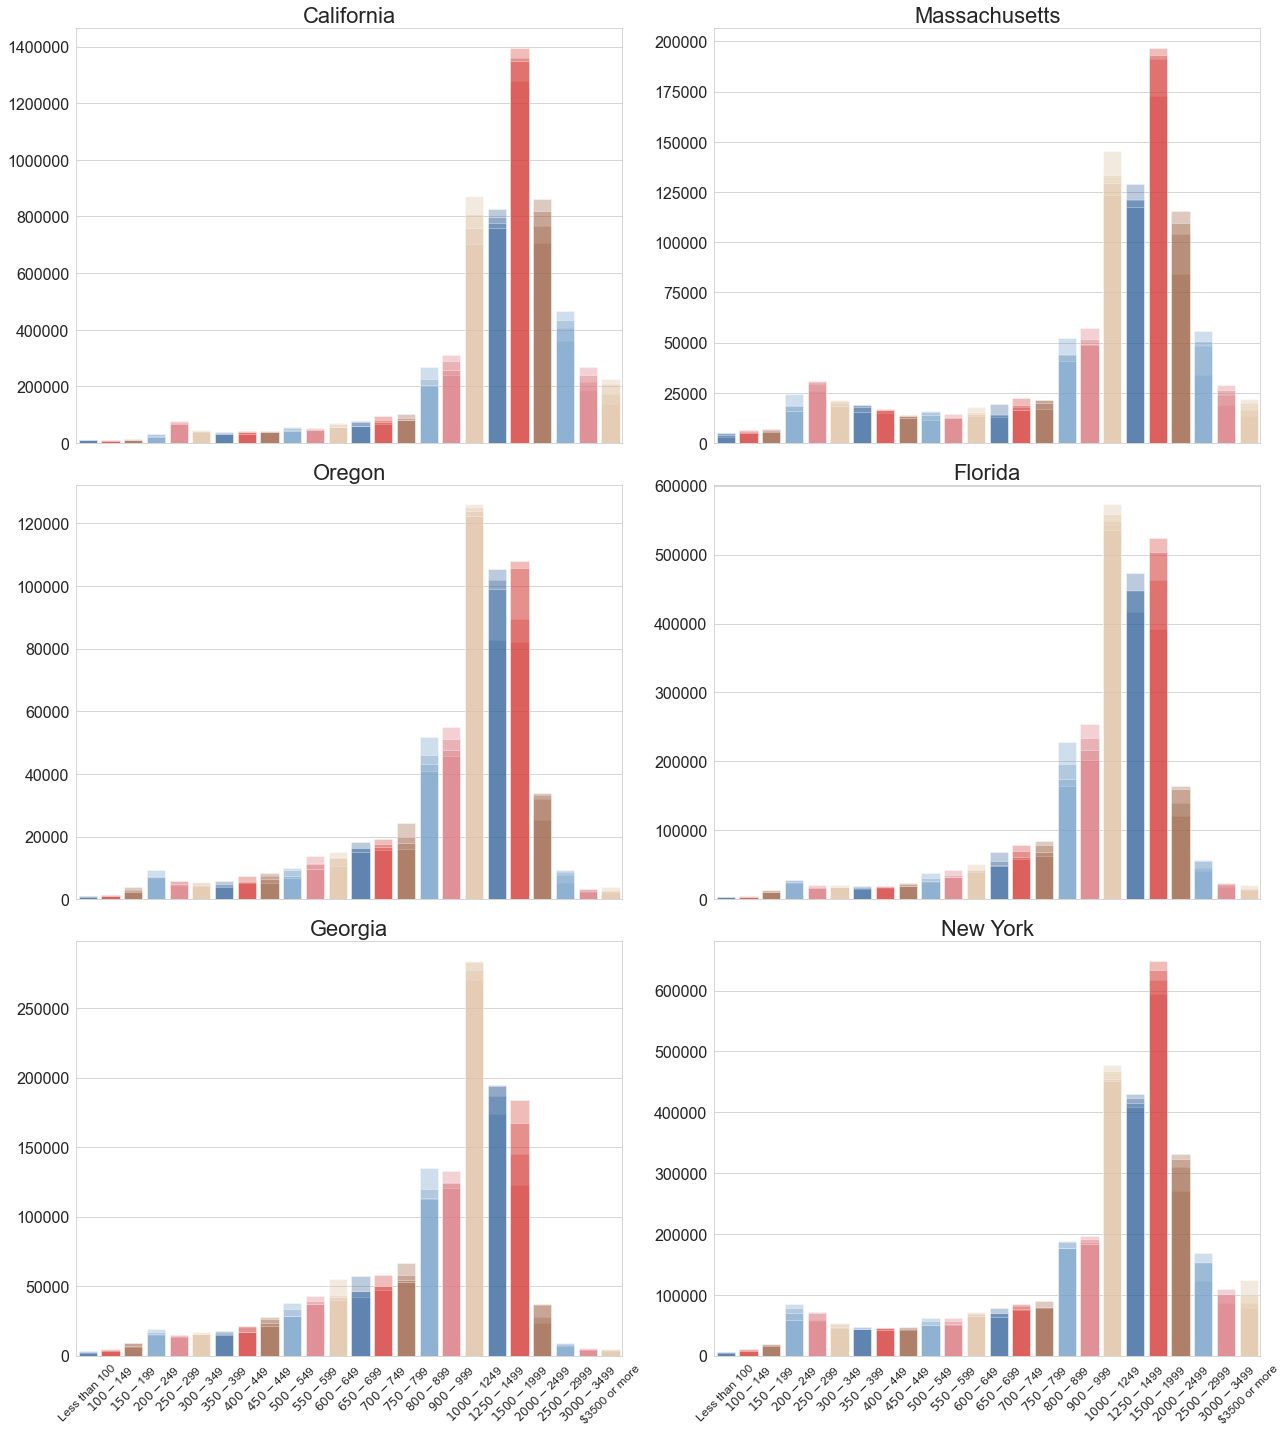

In [307]:
# Create the figure
_, axes = plt.subplots(3, 2, figsize=(18, 20), sharex='col')

for state, ax in zip(list_states, axes.ravel()):
    # The data has to be reformated for the barplot seaborn
    subdata = gross_rent_df.loc(axis=0)[:, state]
    subdata.reset_index(inplace=True)
    subdata = subdata.drop(["id_state", "State name"], axis=1)
    subdata = subdata.T
    subdata.columns = subdata.iloc[0]
    subdata = subdata.drop("Year", axis=0)
    
    for year in years:
        g = sns.barplot(x=subdata.index, y=subdata[year].values,
                        palette = palettable.tableau.BlueRed_6.mpl_colors[:],
                        ax=ax, alpha=0.35)
        g.set_title(state)
        g.tick_params(labelrotation=45, axis='x', labelsize=12)
        g.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

Based on the picture, the most of the renter housing units are in the range of $750 to $2500. However, it is difficult to observe if the number of units has changed over time.

### Cumulative Distribution of renter housing units
Let's plot a cumulative distribution by state by year

In [ ]:
# Back to the original format of the data
gross_rent_df.reset_index(inplace=True)

# Remove id_state because we don't need it
gross_rent_cum_df = gross_rent_df.drop("id_state", axis=1)

# Calculation of the portion of each rent cost range
df1 = gross_rent_cum_df.iloc[:,2:].apply(lambda x: x/x.sum()*100, axis=1)

# Calculation of teh cumulative sum
df1 = df1.apply(lambda x: np.cumsum(x), axis=1)

In [ ]:
df1 = pd.concat([df[["Year","State name"]], df1], axis=1)
df1.set_index(["Year", "State name"], inplace=True)

In [ ]:
df1

In [ ]:
_, axes = plt.subplots(3, 2, figsize=(15, 30))

for state, ax in zip(list_states, axes.ravel()):
    for i, year in enumerate(years):
        g = sns.lineplot(data=df1.loc[(year, state)][11:-3],
                         palette='colorblind', ax=ax, label=year,
                         marker=all_shapes[i],
                         markersize=8)
        g.set_title(state)
        g.set_ylabel("CDF", fontsize=18)
        g.tick_params(axis='y', labelsize=12)
        g.tick_params(labelrotation=45, axis='x', labelsize=12)
        g.ticklabel_format(style='plain', axis='y')
        g.legend(fontsize='large')

plt.tight_layout()
plt.show()